# GeoPick: Centroid and uncertainty calculation
November 2023

---
This Notebook illustrates how __GeoPick__ v1.0.3 applies the point-radius method [[1]](#w2004)
to calculate the centroid (Darwin Core's [decimalLatitude](http://rs.tdwg.org/dwc/terms/decimalLatitude) and [decimalLongitude](http://rs.tdwg.org/dwc/terms/decimalLongitude)) and uncertainty (Darwin Core's [coordinateUncertaintyInMeters](http://rs.tdwg.org/dwc/terms/coordinateUncertaintyInMeters)) associated with a georeferenced locality description (Darwin Core's [verbatimLocality](http://rs.tdwg.org/dwc/terms/verbatimLocality)) by approximating the smallest enclosing circle of a geometry. The example given below is for a polygon with a corrected center [[2](#cw2020), [3](#z2020)]. For line, polyline and multipolygon geometries the calculation is analogous. GeoPick follows steps 1 to 6 to deliver the final results. The case in which the centroid falls on top of the geometry when calculating its smallest enclosing circle would be a simplified version of the process here described, i.e. step 5 below would not be needed. 

In [1]:
import geopandas as gpd
import pandas as pd
import pyproj
import shapely
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import geopick as gp
import ipywidgets as widgets
import sys
import math

random_seed = 42

## 1 - Specimen's locality interpretation
The polygon below represents the geometry resulting from retrospective georeferencing, the process by which the textual description of a locality where a specimen was collected is interpreted over a map. This locality description (Darwin Core's [verbatimLocality](http://rs.tdwg.org/dwc/terms/verbatimLocality)) was available on a specimen's associated metadata, i.e. tag, field notebook, etc. The geometry can be directly digitized with __GeoPick__, imported as [Well-Known Text (WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), or captured from a search to the OpenStreetMap data [Nominatim service](https://nominatim.openstreetmap.org/ui/search.html). The example below corresponds to a locality description of the collection site of a plant in the Cap de Creus area, in northeastern Catalonia, Spain.

#### Run next cell and enter your WKT in the text area below, alternatiely use the one by default

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Create a Textarea widget
textarea_input = widgets.Textarea(
    value='',
    placeholder='Paste your text here',
    # description='WKT:',
    disabled=False,
    layout={'width': '800px', 'height': '300px'}  # Set width and height
)
def clear_wkt_textarea(b):
    # Clear the Textarea by setting its value to an empty string
    textarea_input.value = ""

button = widgets.Button(description="Clear WKT")
button.on_click(clear_wkt_textarea)
box = widgets.VBox([button, textarea_input], layout=widgets.Layout(align_items='flex-start'))

# f_wkt = "../data/capdecreus.txt"
f_wkt = "../data/wkt_different_than_geopickR.txt"
location_wkt = textarea_input.value
location_wkt = pathlib.Path(f_wkt).read_text()
textarea_input.value = location_wkt

display(box)

#### Import WKT

In [3]:
def extract_wkt(items):  
  wkt = None
  for item in items:
    if item.startswith("POINT") or item.startswith("LINESTRING") or \
      item.startswith("MULTILINESTRING") or item.startswith("POLYGON") or \
      item.startswith("MULTIPOLYGON"):
        wkt = item
        break  # Stop searching once a match is found
  return wkt
items = textarea_input.value.split("\t")
location_wkt = extract_wkt(items)

if location_wkt.startswith("POINT"):
  if(len(items) == 1):
    print("POINT geometry, uncertainty not specified.\n")
  else:
    print("POINT geometry.\n")
    print("Latitude:", items[0], ", Longitude:", items[1], ", Uncertainty:", items[3])
  class StopExecution(Exception):
   def _render_traceback_(self):
    return []
  raise StopExecution

#### Load WKT location

In [4]:
location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
location_wgs84.crs = "EPSG:4326"

## 2 - Azimuth Equal-Area projection centered on the locality
In order to correctly calculate the smallest enclosing circle, __GeoPick__ needs to work with an equidistant projection which does not distort distances. GeoPick uses the [Azimuthal Equal Area (AEQD) projection](https://proj.org/en/9.3/operations/projections/aeqd.html) for which all points on the map are at proportionally correct distances from the center. Thus, __GeoPick__ first reprojects the georeferenced geometry from [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) to [AEQD](https://proj.org/en/9.3/operations/projections/aeqd.html), using the centroid corresponding to the locality in [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) as an approximation to the center on which to focus the [AEQD](https://proj.org/en/9.3/operations/projections/aeqd.html) projection.

#### Project location to parameterized AEQD and calculate centroid

/var/folders/yb/wls9204n6hqcz764kjgy_sv80000gn/T/ipykernel_19739/3601518333.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_wgs84 = location_wgs84.centroid
/var/folders/yb/wls9204n6hqcz764kjgy_sv80000gn/T/ipykernel_19739/3601518333.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(xticks, rotation=45); # ; makes xticks not to be printed


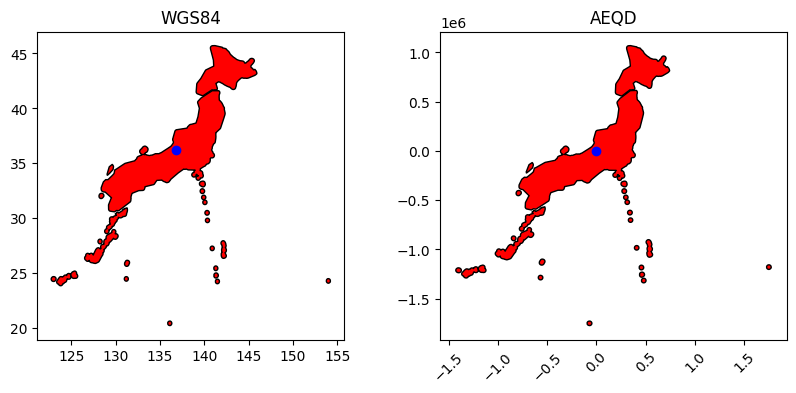

In [5]:
# Get projection focused on WGS84 centroid
centroid_wgs84 = location_wgs84.centroid
proj_aeqd = gp.get_proj_aeqd(centroid_wgs84)
# Project locaiton to AEQD
location_aeqd = location_wgs84.to_crs(proj_aeqd)
centroid_aeqd = centroid_wgs84.to_crs(proj_aeqd)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
location_wgs84.plot(ax=axes[0], color='red', edgecolor='black')
centroid_wgs84.plot(ax=axes[0], color='blue')
axes[0].set_title('WGS84')
location_aeqd.plot(ax=axes[1], color='red', edgecolor='black')
centroid_aeqd.plot(ax=axes[1], color='blue')
axes[1].set_title('AEQD')
xticks = axes[1].get_xticklabels()
axes[1].set_xticklabels(xticks, rotation=45); # ; makes xticks not to be printed

#### Simplify geometry if needed

In [6]:
# Eventual geometry simplification
max_points_polygon =10000
tolerance = 500
location_aeqd = gp.simplify_geometry(location_aeqd)

#### Calculate SEC and its centroid

<Axes: >

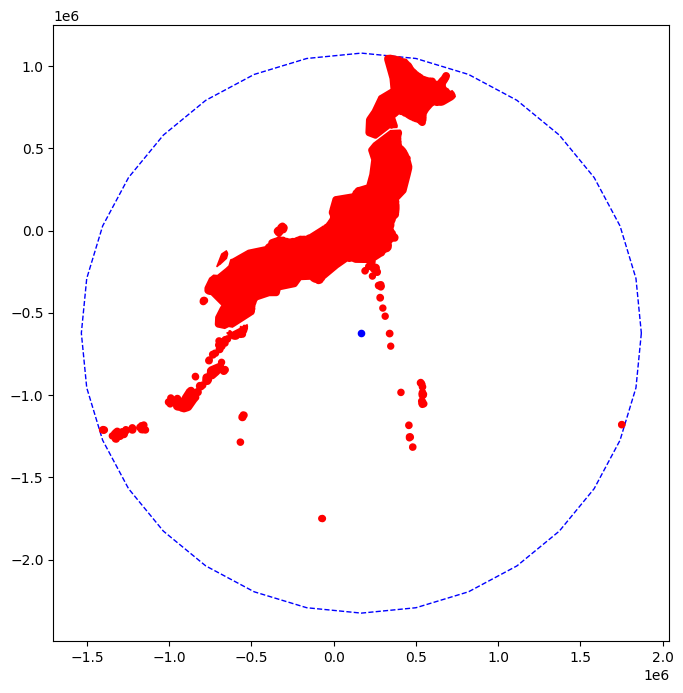

In [7]:
sec_aeqd = gp.get_sec(location_aeqd)
centroid_aeqd = gp.get_sec_centroid(sec_aeqd)
centroid_aeqd.crs = proj_aeqd

fig, ax = plt.subplots(figsize=(8, 8))
sec_aeqd.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)

#### Get all vertices of location

<Axes: >

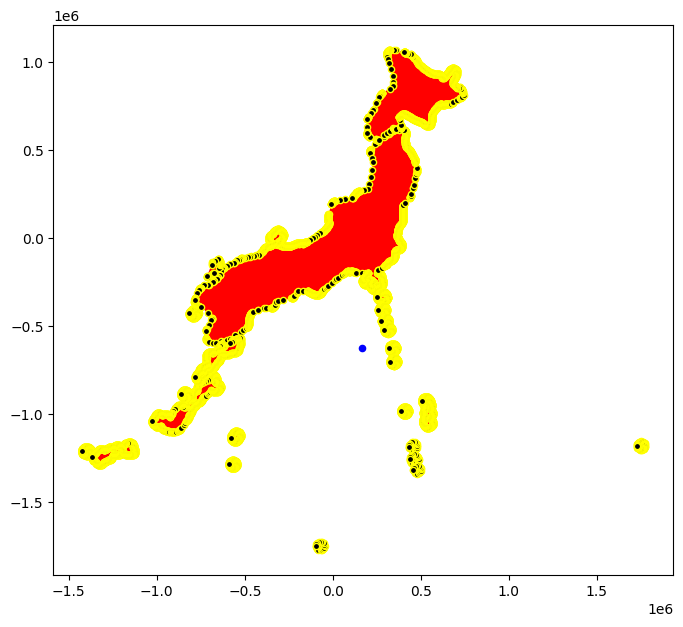

In [8]:
vertices = gp.get_all_vertices(location_aeqd)

fig, ax = plt.subplots(figsize=(8, 8))
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)

#### Calculate nearest point from geometry to centroid

<Axes: >

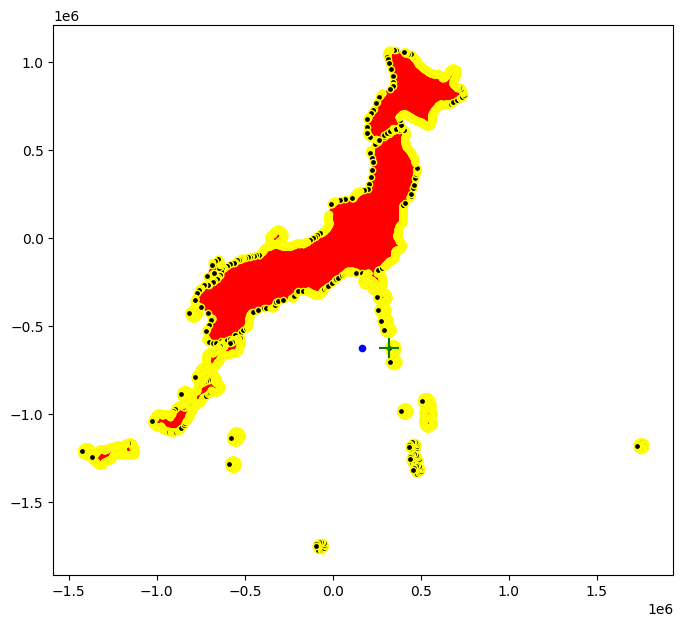

In [9]:
np = gp.get_nearest_point(centroid_aeqd, location_aeqd, proj_aeqd)

fig, ax = plt.subplots(figsize=(8, 8))
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)

## First approximation

<Axes: >

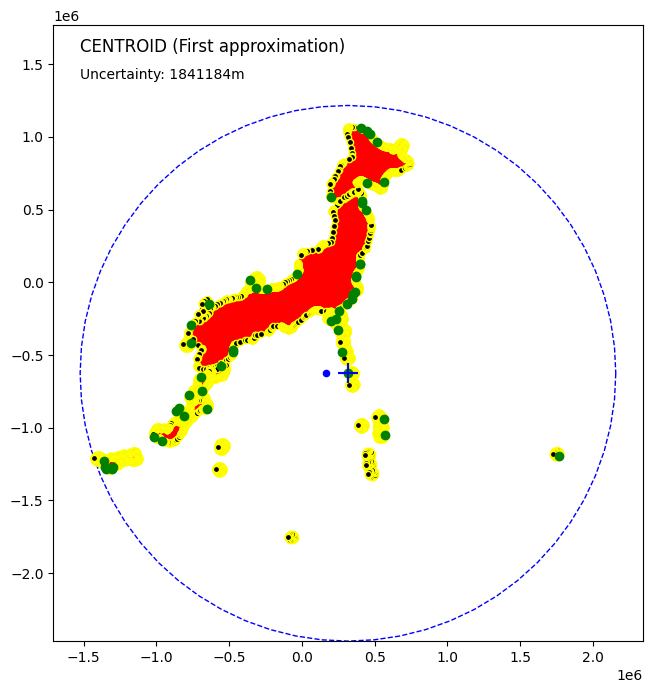

In [10]:
# Get candidate vertices
candidates = gp.get_candidate_vertices(vertices)
# Add nearest point to candidate points
candidates = pd.concat([candidates, np])
candidates = candidates.reset_index(drop=True)

fa = gp.get_minimum_distance_candidate(candidates, vertices)
centroid_fa = gpd.GeoSeries(fa[0])
centroid_fa.crs = proj_aeqd
radius_fa = fa[1]
sec_fa = gpd.GeoSeries(centroid_fa.buffer(radius_fa))
sec_fa.crs = proj_aeqd

bounds = sec_fa.bounds
minx = bounds["minx"].iloc[0]
maxx = bounds["maxx"].iloc[0]
miny = bounds["miny"].iloc[0]
maxy = bounds["maxy"].iloc[0]
y_range = maxy - miny
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny, maxy + 0.15 * y_range)
ax.text(minx, maxy + 0.1 * y_range, 'CENTROID (First approximation)', fontsize=12, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_fa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)


## Second approximation


/Users/arnald/Library/CloudStorage/OneDrive-UAB/wb/GeoPick/py/geopick.py:91: UserWarning: The indices of the two GeoSeries are different.
  distances = point.distance(vertices)


<Axes: >

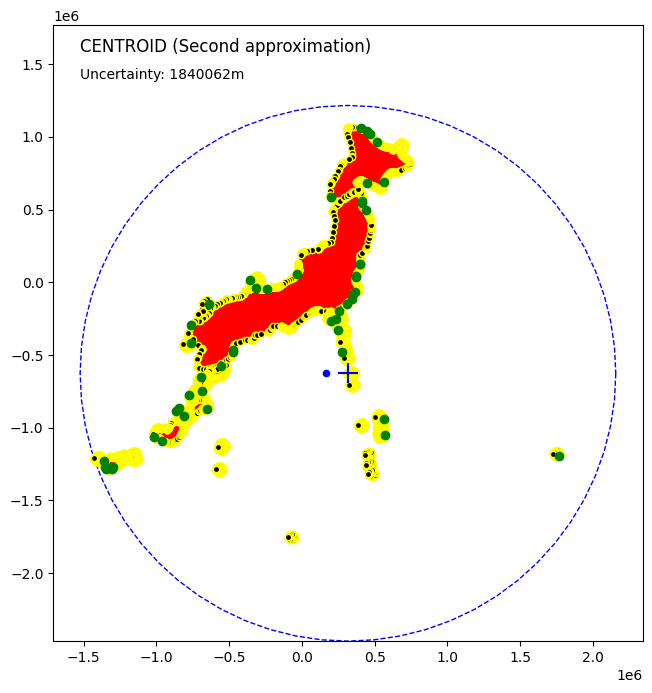

In [11]:
np_centroid_fa = gp.get_nearest_n_vertices(vertices, centroid_fa, 10)
sa = gp.get_minimum_distance_candidate(np_centroid_fa, vertices)
centroid_sa = gpd.GeoSeries(sa[0])
centroid_sa.crs = proj_aeqd
radius_sa = sa[1]
sec_sa = gpd.GeoSeries(centroid_fa.buffer(radius_sa))
sec_sa.crs = proj_aeqd


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny, maxy + 0.15 * y_range)
ax.text(minx, maxy + 0.1 * y_range, 'CENTROID (Second approximation)', fontsize=12, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_sa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
np_centroid_fa.plot(aspect = "equal", color = "yellow", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)

## Final result

<Axes: >

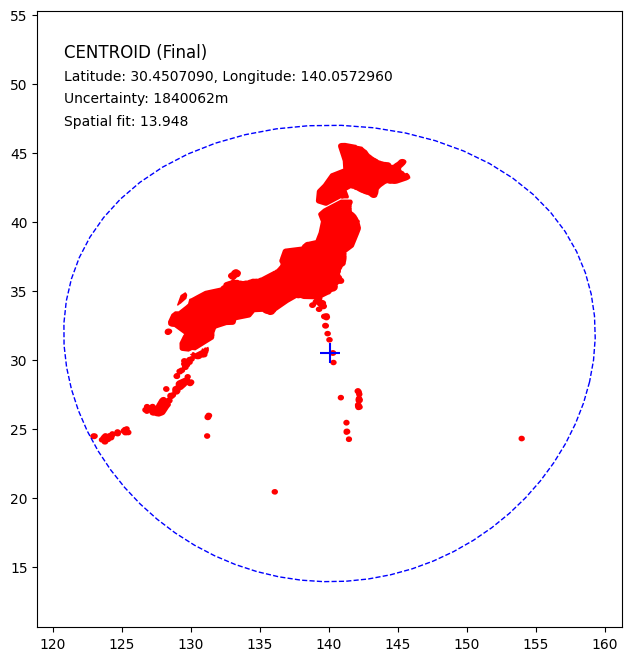

In [12]:
if(radius_sa < radius_fa):
  sec_final = sa
else:
  sec_final = fa

radius_final = sec_final[1]

# Spatial fit
if(location_aeqd.type[0].lower() == 'multipolygon' or location_aeqd.type[0].lower() == 'polygon'):
  spatial_fit = round(radius_final**2 * math.pi / location_aeqd.area[0], 3)
else:
  spatial_fit = ""

centroid_final = gpd.GeoSeries(sec_final[0])
centroid_final.crs = proj_aeqd
sec_final = gpd.GeoSeries(centroid_final.buffer(radius_final))
centroid_final = centroid_final.to_crs(4326)
sec_final = sec_final.to_crs(4326)
centroid_final_coords = centroid_final.get_coordinates()
centroid_string = f"Latitude: {centroid_final_coords['y'].iloc[0]:.7f}, \
Longitude: {centroid_final_coords['x'].iloc[0]:.7f}"

bounds = sec_final.bounds
minx = bounds["minx"].iloc[0]
maxx = bounds["maxx"].iloc[0]
miny = bounds["miny"].iloc[0]
maxy = bounds["maxy"].iloc[0]
y_range = maxy - miny

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny - 0.1 * y_range, maxy + 0.25 * y_range)
ax.text(minx, maxy + 0.15 * y_range, 'CENTROID (Final)', fontsize=12, color='black')
ax.text(minx, maxy + 0.10 * y_range, centroid_string, fontsize=10, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_final:.0f}m", fontsize=10, color='black')
ax.text(minx, maxy + 0 * y_range, f"Spatial fit: {spatial_fit:.3f}", fontsize=10, color='black')

location_wgs84.plot(aspect = "equal", color = "red", ax = ax)
sec_final.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
centroid_final.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)


## References
<a name="w2004">[1]</a> Wieczorek J, Guo Q, Hijmans R. (2004) The point-radius method for georeferencing locality descriptions and calculating associated uncertainty. International Journal of Geographical Information Science. 18:745--767. [https://doi.org/10.1080/13658810412331280211](https://doi.org/10.1080/13658810412331280211).
<a name="cw2020">[2]</a> Chapman AD & Wieczorek JR (2020) Georeferencing Best Practices. Copenhagen: GBIF Secretariat.
[https://doi.org/10.35035/e09p-h128](https://doi.org/10.15468/doc-gg7h-s853)  
<a name="z2020">[3]</a> Zermoglio PF, Chapman AD, Wieczorek JR, Luna MC & Bloom DA (2020) Georeferencing Quick Reference Guide. Copenhagen: GBIF Secretariat. [https://doi.org/10.35035/e09p-h128](https://doi.org/10.35035/e09p-h128)  
<a name="lwgeom2022">[4]</a> Pebesma, E. (2022). lwgeom: Bindings to Selected 'liblwgeom' Functions for Simple Features. R package version 0.2-10. [https://CRAN.R-project.org/package=lwgeom](https://CRAN.R-project.org/package=lwgeom)  
